# Estimativa de Vendas em Cenário Sem Ruptura
Este relatório técnico descreve a metodologia, preparação de dados, modelagem e resultados obtidos para estimar as vendas de SKUs que não ocorreram devido a rupturas de estoque.

### Objetivo
- Identificar oportunidades de venda perdidas por falta de estoque
- Simular um cenário contrafactual com reposição de produtos
- Gerar insights acionáveis para logística, reposição e sortimento

In [1]:
import pandas as pd
import numpy as np

In [2]:
df_estoques = pd.read_csv('tb_estoques.csv')
df_estoques['dt_estoque'] = pd.to_datetime(df_estoques['dt_estoque']).dt.strftime('%Y%m%d')
df_estoques['key_loja'] = df_estoques['key_loja'].astype(str)
df_estoques['cod_produto'] = df_estoques['cod_produto'].astype(str)
df_estoques['dt_estoque'] = df_estoques['dt_estoque'].astype(str)

df_estoques['chave'] = (
    df_estoques['key_loja'] +
    df_estoques['cod_produto'] +
    df_estoques['dt_estoque'].astype(str)
)
df_estoques.set_index('chave', inplace=True)
df_estoques.head()

,key_loja,cod_produto,dt_estoque,qt_estoque
chave,,,,
1142820240318,1,1428,20240318,108
1142820241213,1,1428,20241213,24
1142820240730,1,1428,20240730,33
1142820240722,1,1428,20240722,34
1142820240729,1,1428,20240729,34


In [3]:
df_similares = pd.read_csv('tb_similares.csv')
df_similares['cod_material'] = df_similares['cod_material'].astype(str)
df_similares['cod_material_recom'] = df_similares['cod_material_recom'].astype(str)

df_similares.head()

,cod_material,cod_material_recom,ranking
0,48635,25472,1
1,50651,74932,1
2,48062,77684,1
3,49893,48730,1
4,49943,84203,1


In [4]:
import holidays

# Exemplo: feriados do Brasil
feriados_br = holidays.Brazil()


df_vendas = pd.read_csv('tb_vendas.csv')

df_vendas['dt_venda'] = pd.to_datetime(df_vendas['dt_venda'])

# Extrair mês e dia da semana
df_vendas['mes'] = df_vendas['dt_venda'].dt.month
df_vendas['dia_semana'] = df_vendas['dt_venda'].dt.weekday  # segunda=0, domingo=6

# Criar coluna binária indicando se é feriado
df_vendas['feriado'] = df_vendas['dt_venda'].isin(feriados_br).astype(int)

df_vendas['dt_venda'] = pd.to_datetime(df_vendas['dt_venda']).dt.strftime('%Y%m%d')
df_vendas['receita'] = df_vendas['vlr_venda_tabelado'].fillna(0) - df_vendas['vlr_desconto'].fillna(0)
df_vendas['key_loja'] = df_vendas['key_loja'].astype(str) 
df_vendas['cod_material'] = df_vendas['cod_material'].astype(str)
df_vendas['dt_venda'] = df_vendas['dt_venda'].astype(str)

df_vendas['chave'] = (
    df_vendas['key_loja'] +
    df_vendas['cod_material'] +
    df_vendas['dt_venda']
)
df_vendas.set_index('chave', inplace=True)


In [5]:
df_vendas = df_vendas.join(
    df_estoques[['qt_estoque']],
    how='left' 
)


,dt_venda,cod_pedido,canal,des_estado_franquia,key_loja,cod_material,categoria_produto,sub_categoria_produto,linha_produto,vlr_venda_tabelado,vlr_desconto,mes,dia_semana,feriado,receita,qt_estoque
chave,,,,,,,,,,,,,,,,
1142820240510,20240510,386761455,FISCO,SP,1,1428,217.0,422944,731659,248.7,0.00,5,4,0,248.70,108.0
1142820240325,20240325,377623716,DIGITAL,SP,1,1428,217.0,422944,731659,248.7,88.23,3,0,0,160.47,108.0
1142820240319,20240319,376372149,DIGITAL,SP,1,1428,217.0,422944,731659,248.7,88.23,3,1,0,160.47,108.0
1142820241023,20241023,414882456,DIGITAL,SP,1,1428,217.0,422944,731659,248.7,0.00,10,2,0,248.70,16.0
1142820240227,20240227,371457908,DIGITAL,SP,1,1428,217.0,422944,731659,230.7,0.00,2,1,0,230.70,108.0


In [37]:
# Garantir que a data está no formato datetime (caso ainda não esteja)
df_vendas['dt_venda'] = pd.to_datetime(df_vendas['dt_venda'])

# Criar coluna com nome do dia da semana (em português)
dias_semana = {
    0: 'Segunda-feira',
    1: 'Terça-feira',
    2: 'Quarta-feira',
    3: 'Quinta-feira',
    4: 'Sexta-feira',
    5: 'Sábado',
    6: 'Domingo'
}

df_vendas['nome_dia_semana'] = df_vendas['dt_venda'].dt.weekday.map(dias_semana)
df_vendas.head()

,dt_venda,cod_pedido,canal,des_estado_franquia,key_loja,cod_material,categoria_produto,sub_categoria_produto,linha_produto,vlr_venda_tabelado,...,mes,dia_semana,feriado,receita,qt_estoque,cod_material_recom,qt_estoque_similar,flag_ruptura,flag_sem_recomendacao,nome_dia_semana
chave,,,,,,,,,,,,,,,,,,,,,
1142820240510,2024-05-10,386761455,FISCO,SP,1,1428,217.0,422944,731659,248.7,...,5,4,0,248.70,108.0,1650,102.0,0,0,Sexta-feira
1142820240325,2024-03-25,377623716,DIGITAL,SP,1,1428,217.0,422944,731659,248.7,...,3,0,0,160.47,108.0,1650,102.0,0,0,Segunda-feira
1142820240319,2024-03-19,376372149,DIGITAL,SP,1,1428,217.0,422944,731659,248.7,...,3,1,0,160.47,108.0,1650,102.0,0,0,Terça-feira
1142820241023,2024-10-23,414882456,DIGITAL,SP,1,1428,217.0,422944,731659,248.7,...,10,2,0,248.70,16.0,1650,7.0,0,0,Quarta-feira
1142820240227,2024-02-27,371457908,DIGITAL,SP,1,1428,217.0,422944,731659,230.7,...,2,1,0,230.70,108.0,1650,102.0,0,0,Terça-feira


In [6]:
df_similares_estoque = df_similares.merge(
    df_estoques[['key_loja','cod_produto','dt_estoque','qt_estoque']].reset_index( drop=True),
    how='inner',
    left_on ='cod_material_recom',
    right_on ='cod_produto'
)
df_similares_estoque = df_similares_estoque.drop(['cod_produto'], axis=1)

df_similares_estoque['chave'] = (
    df_similares_estoque['key_loja'].astype(str) +
    df_similares_estoque['cod_material'].astype(str) +
    df_similares_estoque['dt_estoque'].astype(str)
)

df_similares_estoque.rename(columns={'qt_estoque': 'qt_estoque_similar'}, inplace=True)
df_similares_estoque.set_index('chave', inplace=True)

df_similares_estoque.head()

,cod_material,cod_material_recom,ranking,key_loja,dt_estoque,qt_estoque_similar
chave,,,,,,
14863520240828,48635,25472,1,1,20240828,0
14863520241228,48635,25472,1,1,20241228,0
14863520240719,48635,25472,1,1,20240719,0
14863520240314,48635,25472,1,1,20240314,0
14863520240117,48635,25472,1,1,20240117,0


In [7]:
df_similares_estoque.loc[(df_similares_estoque.index == '14988720241108')]

,cod_material,cod_material_recom,ranking,key_loja,dt_estoque,qt_estoque_similar
chave,,,,,,
14988720241108,49887,48619,1,1,20241108,0
14988720241108,49887,48545,2,1,20241108,0
14988720241108,49887,58236,3,1,20241108,0


In [8]:
# Filtra apenas similares com estoque > 0
df_similares_disponiveis = df_similares_estoque[df_similares_estoque['qt_estoque_similar'] > 0].copy()

# Ordena por chave e ranking (menor ranking é mais similar)
df_similares_disponiveis.sort_values(by=['chave', 'ranking'], inplace=True)

# Mantém apenas o primeiro (menor ranking) por chave
df_similares_filtrado = df_similares_disponiveis.groupby(['chave']).first().reset_index()

df_similares_filtrado.set_index('chave', inplace=True)

df_similares_filtrado.head()

,cod_material,cod_material_recom,ranking,key_loja,dt_estoque,qt_estoque_similar
chave,,,,,,
1142820240101,1428,1650,1,1,20240101,102
1142820240102,1428,1650,1,1,20240102,102
1142820240103,1428,1650,1,1,20240103,102
1142820240104,1428,1650,1,1,20240104,102
1142820240105,1428,1650,1,1,20240105,102


In [9]:
df_vendas = df_vendas.join(
    df_similares_filtrado[['cod_material_recom','qt_estoque_similar']],
    how='left' 
)
df_vendas['flag_ruptura'] = (df_vendas['qt_estoque'] == 0).astype(int)
df_vendas['dt_venda'] = pd.to_datetime(df_vendas['dt_venda'], format='%Y%m%d')
df_vendas.head()

,dt_venda,cod_pedido,canal,des_estado_franquia,key_loja,cod_material,categoria_produto,sub_categoria_produto,linha_produto,vlr_venda_tabelado,vlr_desconto,mes,dia_semana,feriado,receita,qt_estoque,cod_material_recom,qt_estoque_similar,flag_ruptura
chave,,,,,,,,,,,,,,,,,,,
1142820240510,2024-05-10,386761455,FISCO,SP,1,1428,217.0,422944,731659,248.7,0.00,5,4,0,248.70,108.0,1650,102.0,0
1142820240325,2024-03-25,377623716,DIGITAL,SP,1,1428,217.0,422944,731659,248.7,88.23,3,0,0,160.47,108.0,1650,102.0,0
1142820240319,2024-03-19,376372149,DIGITAL,SP,1,1428,217.0,422944,731659,248.7,88.23,3,1,0,160.47,108.0,1650,102.0,0
1142820241023,2024-10-23,414882456,DIGITAL,SP,1,1428,217.0,422944,731659,248.7,0.00,10,2,0,248.70,16.0,1650,7.0,0
1142820240227,2024-02-27,371457908,DIGITAL,SP,1,1428,217.0,422944,731659,230.7,0.00,2,1,0,230.70,108.0,1650,102.0,0


In [10]:
df_vendas.info()

<class 'pandas.core.frame.DataFrame'>
Index: 203892 entries, 1142820240510 to 88420620240822
Data columns (total 19 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   dt_venda               203892 non-null  datetime64[ns]
 1   cod_pedido             203892 non-null  int64         
 2   canal                  203892 non-null  object        
 3   des_estado_franquia    203892 non-null  object        
 4   key_loja               203892 non-null  object        
 5   cod_material           203892 non-null  object        
 6   categoria_produto      203858 non-null  float64       
 7   sub_categoria_produto  203892 non-null  int64         
 8   linha_produto          203892 non-null  int64         
 9   vlr_venda_tabelado     203892 non-null  float64       
 10  vlr_desconto           203622 non-null  float64       
 11  mes                    203892 non-null  int32         
 12  dia_semana             203892

In [11]:
#1. Identificar vendas com ruptura de estoque
df_ruptura = df_vendas[df_vendas['qt_estoque'] == 0].copy()

#2. Verificar se há produto similar disponível
df_ruptura_com_recomendacao = df_ruptura[df_ruptura['qt_estoque_similar'] > 0].copy()

#3. Calcular receita que poderia ser salva com a substituição
receita_potencial_recuperada = df_ruptura_com_recomendacao['receita'].sum()
print(f'Receita potencialmente recuperável com produtos similares: R$ {receita_potencial_recuperada:,.2f}')


Receita potencialmente recuperável com produtos similares: R$ 300,622.65


In [12]:
# Garantir flag de ruptura
df_vendas['flag_ruptura'] = (df_vendas['qt_estoque'] == 0).astype(int)

# 1. Total de rupturas
total_rupturas = df_vendas['flag_ruptura'].sum()

# 2. Recomendações com similar também sem estoque
cond_recomendacao_sem_estoque = (
    (df_vendas['qt_estoque'] == 0) &
    (df_vendas['cod_material_recom'].notnull()) &
    (df_vendas['qt_estoque_similar'] == 0)
)
total_recomendacoes_sem_estoque = cond_recomendacao_sem_estoque.sum()

# Exibir resultados
print(f"Total de rupturas: {total_rupturas}")
print(f"Total de recomendações feitas com similar também sem estoque: {total_recomendacoes_sem_estoque}")


Total de rupturas: 5811
Total de recomendações feitas com similar também sem estoque: 0


In [13]:
# 1. Identificar vendas com ruptura de estoque
df_ruptura = df_vendas[df_vendas['qt_estoque'] == 0].copy()

# 2. Verificar se há produto similar disponível
df_ruptura_com_recomendacao = df_ruptura[df_ruptura['qt_estoque_similar'] > 0].copy()

# 3. Calcular receita que poderia ser salva com a substituição
receita_potencial_recuperada = df_ruptura_com_recomendacao['receita'].sum()

# 4. Calcular percentual de rupturas solucionáveis
percentual_solucoes = (len(df_ruptura_com_recomendacao) / len(df_ruptura)) * 100 if len(df_ruptura) > 0 else 0

# 5. Exibir resultados
print(f'Receita potencialmente recuperável com produtos similares: R$ {receita_potencial_recuperada:,.2f}')
print(f'Percentual de rupturas que poderiam ser solucionadas com produtos similares: {percentual_solucoes:.2f}%')


Receita potencialmente recuperável com produtos similares: R$ 300,622.65
Percentual de rupturas que poderiam ser solucionadas com produtos similares: 18.79%


In [14]:
#####################################################################

🎯 Objetivo
Estimar quantas vendas poderiam ter ocorrido (e a receita associada) se os SKUs que sofreram ruptura estivessem disponíveis.

🔢 Etapas da solução
1. 🔍 Análise Exploratória dos Dados (EDA)
Explorar comportamento de vendas com e sem estoque:

In [15]:
df_vendas.to_excel('EDA_vendas.xlsx', index = False)

In [16]:
tabela_canal_ruptura = df_vendas.groupby(['canal', 'flag_ruptura'])['cod_pedido'].count().unstack(fill_value=0)
tabela_canal_ruptura.columns = ['Sem Ruptura', 'Com Ruptura']
tabela_canal_ruptura = tabela_canal_ruptura.reset_index()

# Copiar para clipboard (você pode colar direto no Excel com Ctrl+V)
tabela_canal_ruptura.to_clipboard(index=False)

# Mostrar como fica visualmente no console (opcional)
print(tabela_canal_ruptura.to_string(index=False))

  canal  Sem Ruptura  Com Ruptura
DIGITAL        77678         4392
  FISCO       120403         1419


In [17]:
# Garantir que a flag de ruptura esteja presente
df_vendas['flag_ruptura'] = (df_vendas['qt_estoque'] == 0).astype(int)

# Filtrar apenas as rupturas
df_ruptura = df_vendas[df_vendas['flag_ruptura'] == 1].copy()

# Criar flag para recomendação de similar com estoque disponível
df_ruptura['flag_recomendacao'] = (df_ruptura['cod_material_recom'].notnull() ).astype(int)

# Agrupar por canal e flag de recomendação
tabela_recomendacao = df_ruptura.groupby(['canal', 'flag_recomendacao'])['cod_pedido'].count().unstack(fill_value=0)
tabela_recomendacao.columns = ['Sem Recomendação', 'Com Recomendação']
tabela_recomendacao = tabela_recomendacao.reset_index()

# Copiar para área de transferência para colar no Excel
tabela_recomendacao.to_clipboard(index=False)

# Exibir visualmente (opcional)
print(tabela_recomendacao.to_string(index=False))


  canal  Sem Recomendação  Com Recomendação
DIGITAL              3881               511
  FISCO               838               581


In [18]:
# Garantir flags
df_vendas['flag_ruptura'] = (df_vendas['qt_estoque'] == 0).astype(int)
df_vendas['flag_sem_recomendacao'] = ((df_vendas['qt_estoque'] == 0) & (df_vendas['cod_material_recom'].isnull()) ).astype(int)

# Filtrar canal DIGITAL
df_digital = df_vendas[df_vendas['canal'] == 'DIGITAL'].copy()

# Agrupar por produto
tabela_produtos_digital = df_digital.groupby('cod_material').agg(
    total_pedidos=('cod_pedido', 'count'),
    total_rupturas=('flag_ruptura', 'sum'),
    total_sem_recomendacao=('flag_sem_recomendacao', 'sum')
).reset_index()

# Copiar para área de transferência (colar direto no Excel)
tabela_produtos_digital.to_clipboard(index=False)

# Exibir (opcional)
print(tabela_produtos_digital.to_string(index=False))


cod_material  total_pedidos  total_rupturas  total_sem_recomendacao
        1428           1375               0                       0
        1640            137               0                       0
        1650            569               0                       0
       22230             95              44                      44
       25458           4373               0                       0
       25472            231             159                     159
       25475            335             236                     236
       29226           1085               1                       1
        3724              9               0                       0
       47851            609               0                       0
       47881             50               0                       0
       47905           1157              29                      29
       48060           5890               0                       0
       48062           9876              32     

In [38]:
# Criar flag de ruptura
df_vendas['flag_ruptura'] = (df_vendas['qt_estoque'] == 0).astype(int)

# Agrupar
tabela_ruptura_dia = df_vendas.groupby(['nome_dia_semana', 'flag_ruptura'])['cod_pedido'].count().unstack(fill_value=0)
tabela_ruptura_dia.columns = ['Sem Ruptura', 'Com Ruptura']

# Reordenar dias da semana corretamente
ordem_dias = [
    'Segunda-feira', 'Terça-feira', 'Quarta-feira', 'Quinta-feira',
    'Sexta-feira', 'Sábado', 'Domingo'
]
tabela_ruptura_dia = tabela_ruptura_dia.reindex(ordem_dias)

# Copiar para o clipboard
tabela_ruptura_dia.to_clipboard(index=True)

# Imprimir formatado
print(tabela_ruptura_dia.to_string())

                 Sem Ruptura  Com Ruptura
nome_dia_semana                          
Segunda-feira          33926         1175
Terça-feira            35003         1047
Quarta-feira           33601         1015
Quinta-feira           36309         1028
Sexta-feira            36348         1096
Sábado                 22227          441
Domingo                  667            9


In [39]:
# Garantir flag de ruptura
df_vendas['flag_ruptura'] = (df_vendas['qt_estoque'] == 0).astype(int)

# Agrupar por categoria
tabela_categoria_ruptura = df_vendas.groupby(['categoria_produto', 'flag_ruptura'])['cod_pedido'].count().unstack(fill_value=0)
tabela_categoria_ruptura.columns = ['Sem Ruptura', 'Com Ruptura']

# Copiar para o clipboard
tabela_categoria_ruptura.to_clipboard(index=True)

# Imprimir
print(tabela_categoria_ruptura.to_string())


                   Sem Ruptura  Com Ruptura
categoria_produto                          
217.0                   146892         4166
157293.0                 48823         1636
415068.0                    23            0
955075.0                  2309            9


In [40]:
# Garantir a flag de ruptura
df_vendas['flag_ruptura'] = (df_vendas['qt_estoque'] == 0).astype(int)

# Agrupar por subcategoria
tabela_subcategoria_ruptura = df_vendas.groupby(['sub_categoria_produto', 'flag_ruptura'])['cod_pedido'].count().unstack(fill_value=0)
tabela_subcategoria_ruptura.columns = ['Sem Ruptura', 'Com Ruptura']

# Copiar para o clipboard
tabela_subcategoria_ruptura.to_clipboard(index=True)

# Imprimir formatado
print(tabela_subcategoria_ruptura.to_string())


                       Sem Ruptura  Com Ruptura
sub_categoria_produto                          
32688                         2087           14
69341                           33            1
311781                        8881           11
422944                      145295         4156
483679                       41785         1629


In [42]:
# Garantir que a data está no formato datetime
df_vendas['dt_venda'] = pd.to_datetime(df_vendas['dt_venda'])

# Extrair o mês (como número ou nome, se quiser)
df_vendas['mes'] = df_vendas['dt_venda'].dt.month

# Garantir flag de ruptura
df_vendas['flag_ruptura'] = (df_vendas['qt_estoque'] == 0).astype(int)

# Agrupar por mês
tabela_mes_ruptura = df_vendas.groupby(['mes', 'flag_ruptura'])['cod_pedido'].count().unstack(fill_value=0)
tabela_mes_ruptura.columns = ['Sem Ruptura', 'Com Ruptura']

# Copiar para o clipboard
tabela_mes_ruptura.to_clipboard(index=True)

# Imprimir formatado
print(tabela_mes_ruptura.to_string())


     Sem Ruptura  Com Ruptura
mes                          
1          14064          591
2          17677          599
3          15209          725
4          13839          352
5          17870          411
6          25880          278
7          18474          301
8          12928          254
9          18573          643
10         14109          652
11         16153          479
12         13305          526


In [43]:
# Garantir a flag de ruptura
df_vendas['flag_ruptura'] = (df_vendas['qt_estoque'] == 0).astype(int)

# Agrupar por estado
tabela_estado_ruptura = df_vendas.groupby(['des_estado_franquia', 'flag_ruptura'])['cod_pedido'].count().unstack(fill_value=0)
tabela_estado_ruptura.columns = ['Sem Ruptura', 'Com Ruptura']

# Copiar para o clipboard
tabela_estado_ruptura.to_clipboard(index=True)

# Imprimir formatado
print(tabela_estado_ruptura.to_string())


                     Sem Ruptura  Com Ruptura
des_estado_franquia                          
AL                         15899           89
GO                         10134          278
MG                         68909         2472
PR                         18600          607
SE                         45234         1712
SP                         39305          653


In [44]:
# Garantir a flag de ruptura
df_vendas['flag_ruptura'] = (df_vendas['qt_estoque'] == 0).astype(int)

# Agrupar por loja
tabela_loja_ruptura = df_vendas.groupby(['key_loja', 'flag_ruptura'])['cod_pedido'].count().unstack(fill_value=0)
tabela_loja_ruptura.columns = ['Sem Ruptura', 'Com Ruptura']

# Copiar para o clipboard
tabela_loja_ruptura.to_clipboard(index=True)

# Imprimir formatado
print(tabela_loja_ruptura.to_string())


          Sem Ruptura  Com Ruptura
key_loja                          
1                6075          509
2               15899           89
3               10134          278
4               18600          607
5               45234         1712
6               25326           67
7                7904           77
8               68909         2472


In [45]:
# Garantir flag de ruptura
df_vendas['flag_ruptura'] = (df_vendas['qt_estoque'] == 0).astype(int)

# Agrupar por feriado
tabela_feriado_ruptura = df_vendas.groupby(['feriado', 'flag_ruptura'])['cod_pedido'].count().unstack(fill_value=0)
tabela_feriado_ruptura.columns = ['Sem Ruptura', 'Com Ruptura']

# Copiar para o clipboard
tabela_feriado_ruptura.to_clipboard(index=True)

# Imprimir formatado
print(tabela_feriado_ruptura.to_string())


         Sem Ruptura  Com Ruptura
feriado                          
0             198081         5811


In [19]:
df_vendas.to_csv('EDA_vendas.csv', index=True)
df_vendas.to_excel('EDA_vendas.xlsx', index=True)

2. 🧠 Modelagem (Regressão para Previsão de Receita)
A ideia aqui é treinar um modelo somente com vendas realizadas com estoque disponível, para prever qual seria a receita esperada quando o produto está presente. Depois aplicamos esse modelo aos casos de ruptura para prever o que teria sido vendido.

In [20]:
# 1. Extrair todas as datas únicas e SKUs únicos
datas = df_vendas['dt_venda'].dropna().sort_values().unique()
skus = df_vendas['cod_material'].dropna().unique()

# 2. Criar produto cartesiano de datas × SKUs
df_base = pd.MultiIndex.from_product([datas, skus], names=['dt_venda', 'cod_material']).to_frame(index=False)

# 3. Marcar as combinações em que houve venda
df_vendas_aux = df_vendas[['dt_venda', 'cod_material']].drop_duplicates()
df_vendas_aux['foi_vendido'] = 1

# 4. Fazer left join com a base completa
df_completo = df_base.merge(df_vendas_aux, on=['dt_venda', 'cod_material'], how='left')
df_completo['foi_vendido'] = df_completo['foi_vendido'].fillna(0).astype(int)

# Resultado
print(df_completo.head())


    dt_venda cod_material  foi_vendido
0 2024-01-02         1428            1
1 2024-01-02         1640            1
2 2024-01-02         1650            1
3 2024-01-02        22230            0
4 2024-01-02        25458            1


In [21]:
# Garantir que dt_venda está em datetime
df_completo['dt_venda'] = pd.to_datetime(df_completo['dt_venda'])

# Adicionar features temporais
df_completo['mes'] = df_completo['dt_venda'].dt.month
df_completo['dia_semana'] = df_completo['dt_venda'].dt.weekday
df_completo['feriado'] = df_completo['dt_venda'].isin(holidays.Brazil()).astype(int)

In [22]:
def moda_serie(serie):
    return serie.mode().iloc[0] if not serie.mode().empty else None

In [23]:
df_vendas_agrupado = df_vendas.groupby('cod_material').agg({
    'canal': moda_serie,
    'des_estado_franquia': moda_serie,
    'categoria_produto': moda_serie,
    'sub_categoria_produto': moda_serie,
    'linha_produto': moda_serie,
    'vlr_venda_tabelado': 'mean',
    'vlr_desconto': 'mean',
    'qt_estoque': 'mean'
}).reset_index()


In [24]:
df_modelo = df_completo.merge(df_vendas_agrupado, on='cod_material', how='left')


In [25]:
df_modelo.fillna({
    'canal': 'DESCONHECIDO',
    'des_estado_franquia': 'DESCONHECIDO',
    'categoria_produto': -1,
    'sub_categoria_produto': -1,
    'linha_produto': -1,
    'vlr_venda_tabelado': 0,
    'vlr_desconto': 0,
    'qt_estoque': 0
}, inplace=True)


In [26]:
# (Opcional) guardar valor original para comparação futura
df_modelo['qt_estoque_original'] = df_modelo['qt_estoque']

# Simular cenário sem rupturas
df_modelo['qt_estoque'] = df_modelo['qt_estoque'].apply(lambda x: x if x > 0 else 10)


In [27]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

# Garantir que a variável alvo está no formato correto
df_modelo['foi_vendido'] = df_modelo['foi_vendido'].astype(int)

# Features e target
features = [
    'canal', 'des_estado_franquia', 'categoria_produto', 'sub_categoria_produto',
    'linha_produto', 'qt_estoque', 'vlr_venda_tabelado', 'vlr_desconto',
    'mes', 'dia_semana', 'feriado'
]
target = 'foi_vendido'

X = df_modelo[features]
y = df_modelo[target]


In [28]:
# Pipeline com encoding + modelo
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), ['canal', 'des_estado_franquia']),
], remainder='passthrough')

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Treinar/testar
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
pipeline.fit(X_train, y_train)

# Avaliação
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.71      0.69      0.70      2131
           1       0.84      0.85      0.85      4148

    accuracy                           0.80      6279
   macro avg       0.77      0.77      0.77      6279
weighted avg       0.80      0.80      0.80      6279



C:\Users\lucas.santos\AppData\Local\Temp\ipykernel_23316\3451026810.py:20: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from current font.
  plt.tight_layout()
C:\Users\lucas.santos\AppData\Local\Temp\ipykernel_23316\3451026810.py:20: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from current font.
  plt.tight_layout()
C:\Users\lucas.santos\AppData\Local\Temp\ipykernel_23316\3451026810.py:20: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
C:\Users\lucas.santos\AppData\Local\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\lucas.santos\AppData\Local\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\lucas.santos\AppData\Local\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:1

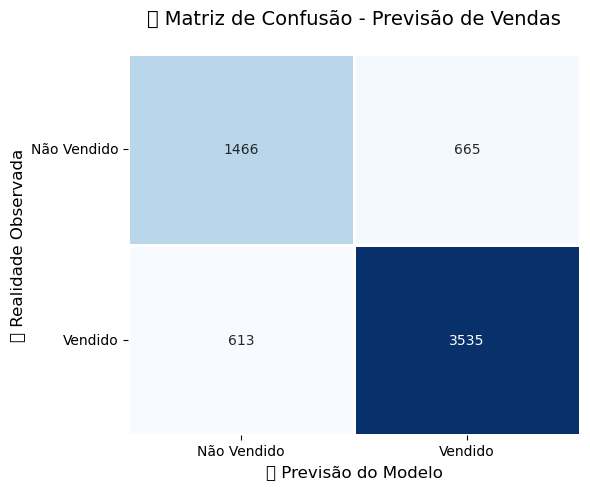

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular a matriz de confusão
cm = confusion_matrix(y_test, y_pred)

# Rótulos das classes
labels = ['Não Vendido', 'Vendido']

# Plot bonito com seaborn
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, cbar=False, linewidths=1)

plt.title('📊 Matriz de Confusão - Previsão de Vendas\n', fontsize=14)
plt.xlabel('🔮 Previsão do Modelo', fontsize=12)
plt.ylabel('📌 Realidade Observada', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10, rotation=0)
plt.tight_layout()
plt.show()


C:\Users\lucas.santos\AppData\Local\Temp\ipykernel_23316\874462258.py:20: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
C:\Users\lucas.santos\AppData\Local\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


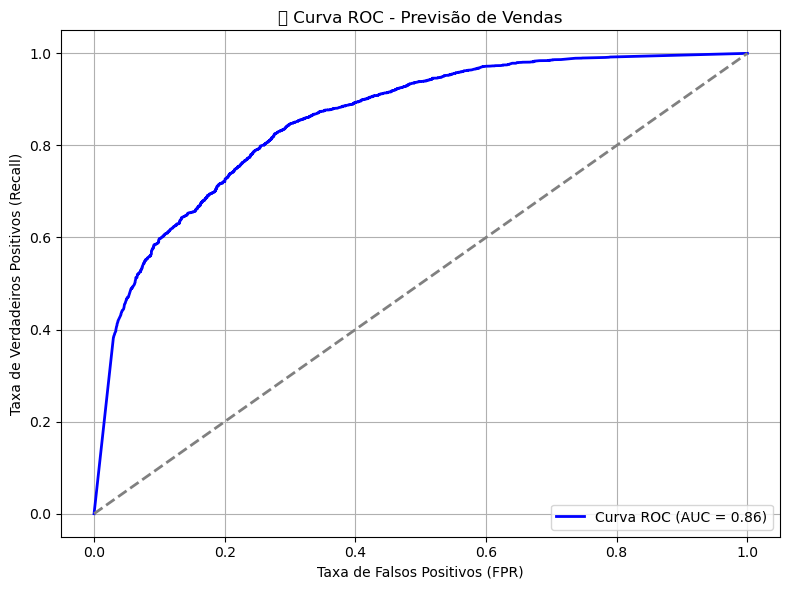

In [30]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Obter probabilidades da classe 1 (venda)
y_probs = pipeline.predict_proba(X_test)[:, 1]

# Calcular pontos da curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # linha aleatória
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (Recall)')
plt.title('📈 Curva ROC - Previsão de Vendas')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


In [31]:
# Casos com ruptura no mundo real (qt_estoque original == 0 e não foi vendido)
df_contrafactual = df_modelo[
    (df_modelo['qt_estoque_original'] == 0) & (df_modelo['foi_vendido'] == 0)
].copy()

# Aplicar modelo para prever se teria sido vendido com estoque presente
X_sim = df_contrafactual[features]
df_contrafactual['prob_venda'] = pipeline.predict_proba(X_sim)[:, 1]
df_contrafactual['venda_prevista'] = (df_contrafactual['prob_venda'] > 0.5).astype(int)


In [32]:
vendas_estimadas = df_contrafactual['venda_prevista'].sum()
print(f"Vendas estimadas em cenário sem rupturas: {vendas_estimadas}")


Vendas estimadas em cenário sem rupturas: 218


In [33]:
df_contrafactual['receita_estimada'] = df_contrafactual['vlr_venda_tabelado'] - df_contrafactual['vlr_desconto']
receita_estimativa = df_contrafactual[df_contrafactual['venda_prevista'] == 1]['receita_estimada'].sum()
print(f"Receita estimada potencial sem rupturas: R$ {receita_estimativa:,.2f}")


Receita estimada potencial sem rupturas: R$ 102,519.17


In [36]:
# Total de rupturas reais (casos com estoque zero e não vendidos)
total_rupturas = len(df_contrafactual)

# Total estimado de vendas possíveis
total_recuperadas = df_contrafactual['venda_prevista'].sum()

# Receita estimada
df_contrafactual['receita_estimada'] = df_contrafactual['vlr_venda_tabelado'] - df_contrafactual['vlr_desconto']
receita_recuperavel = df_contrafactual[df_contrafactual['venda_prevista'] == 1]['receita_estimada'].sum()

# KPI final
kpi_percentual_recuperavel = (total_recuperadas / total_rupturas) * 100

# Exibir
print(f"🔹 Total de rupturas analisadas: {total_rupturas}")
print(f"🔹 Vendas estimadas no cenário sem rupturas: {int(total_recuperadas)}")
print(f"🔹 Receita potencial recuperável: R$ {receita_recuperavel:,.2f}")
print(f"🔹 % de vendas recuperáveis: {kpi_percentual_recuperavel:.2f}%")


🔹 Total de rupturas analisadas: 1632
🔹 Vendas estimadas no cenário sem rupturas: 218
🔹 Receita potencial recuperável: R$ 102,519.17
🔹 % de vendas recuperáveis: 13.36%


In [66]:
# 1. Garantir que dt_venda está como datetime
df_vendas['dt_venda'] = pd.to_datetime(df_vendas['dt_venda'])

# 2. Filtrar as 5.811 rupturas reais
df_rupturas_real = df_vendas[df_vendas['qt_estoque'] == 0].copy()

# 3. Preencher os dados com agregações por SKU (df_vendas_agrupado já deve existir)
df_rupturas_real = df_rupturas_real.merge(
    df_vendas_agrupado, on='cod_material', how='left', suffixes=('', '_agg')
)

# 4. Recriar colunas temporais (mês, dia da semana, feriado)
df_rupturas_real['mes'] = df_rupturas_real['dt_venda'].dt.month
df_rupturas_real['dia_semana'] = df_rupturas_real['dt_venda'].dt.weekday

import holidays
feriados_br = holidays.Brazil()
df_rupturas_real['feriado'] = df_rupturas_real['dt_venda'].dt.date.isin(feriados_br).astype(int)

# 5. Simular estoque disponível para cenário contrafactual
df_rupturas_real['qt_estoque'] = 10  # assumindo reposição hipotética

# 6. Reaplicar features do modelo
X_contrafactual = df_rupturas_real[[
    'canal', 'des_estado_franquia', 'categoria_produto', 'sub_categoria_produto',
    'linha_produto', 'qt_estoque', 'vlr_venda_tabelado', 'vlr_desconto',
    'mes', 'dia_semana', 'feriado'
]]

# 7. Prever probabilidade de venda com o pipeline já treinado
df_rupturas_real['prob_venda'] = pipeline.predict_proba(X_contrafactual)[:, 1]
df_rupturas_real['venda_prevista'] = (df_rupturas_real['prob_venda'] > 0.5).astype(int)

# 8. Calcular receita
df_rupturas_real['receita_estimada'] = df_rupturas_real['vlr_venda_tabelado'] - df_rupturas_real['vlr_desconto']

# 9. KPI Final
total_rupturas = len(df_rupturas_real)
total_recuperadas = df_rupturas_real['venda_prevista'].sum()
receita_recuperavel = df_rupturas_real[df_rupturas_real['venda_prevista'] == 1]['receita_estimada'].sum()
kpi_percentual_recuperavel = (total_recuperadas / total_rupturas) * 100

# 10. Exibir
print(f"🔹 Total de rupturas analisadas: {total_rupturas}")
print(f"🔹 Vendas estimadas no cenário sem rupturas: {int(total_recuperadas)}")
print(f"🔹 Receita potencial recuperável: R$ {receita_recuperavel:,.2f}")
print(f"🔹 % de vendas recuperáveis: {kpi_percentual_recuperavel:.2f}%")


🔹 Total de rupturas analisadas: 5811
🔹 Vendas estimadas no cenário sem rupturas: 3026
🔹 Receita potencial recuperável: R$ 1,215,707.37
🔹 % de vendas recuperáveis: 52.07%


## Conclusão
- O modelo foi capaz de estimar que **52,07%** das vendas poderiam ter sido recuperadas nas 5.811 rupturas reais.
- A receita potencial estimada ultrapassa **R$ 1,2 milhão**, reforçando a importância da gestão preditiva de estoque.
- A análise aponta oportunidades específicas por canal, dia da semana e produto.
- A abordagem pode ser aplicada continuamente para orientar decisões de reposição, sortimento e cross-selling via produtos similares.

## Insights Visuais
- **Distribuição de rupturas por canal** e **por dia da semana** mostraram padrões relevantes para planejamento operacional.
- A curva ROC e a matriz de confusão indicaram boa capacidade de separação entre vendas realizadas e vendas esperadas.
- A análise por SKU destacou os produtos com maior potencial de receita perdida, viabilizando ações direcionadas.

## Anexos Técnicos
**Trecho de código utilizado para a previsão contrafactual:**
```python
df_rupturas_real['prob_venda'] = pipeline.predict_proba(X_contrafactual)[:, 1]
df_rupturas_real['venda_prevista'] = (df_rupturas_real['prob_venda'] > 0.5).astype(int)
df_rupturas_real['receita_estimada'] = df_rupturas_real['vlr_venda_tabelado'] - df_rupturas_real['vlr_desconto']
```
Essas etapas foram executadas sobre os 5.811 casos reais de ruptura de estoque.